### 增强数据处理
- 项目中提供了一个额外的[扩充数据](http://www.robots.ox.ac.uk/%7Evgg/data/pets/)，数据集情况如下图
- ![Extra data](images/breeds.jpg)

- 数据解压后全部包含在一个文件中，文件名的格式为{种类}_{序号}.jpg，比如 Abyssinian_1.jpg
- 因此我们需要根据上方图片提供的分类信息来进行图片的分类，比如Abyssinian是猫，所以应该把图片Abyssinian_1.jpg分类到train/cat的目录下面
- 图片有一处错误萨摩耶应该是samoyed而不是samyoed

In [4]:
import os

dog_breeds = ['american_bulldog', 'american_pit_bull_terrier','basset_hound','beagle','boxer',
             'chihuahua','english_cocker_spaniel','english_setter','german_shorthaired','great_pyrenees',
             'havanese','japanese_chin','keeshond','leonberger','miniature_pinscher','newfoundland','pomeranian',
             'pug','saint_bernard','samoyed','scottish_terrier','shiba_inu','staffordshire_bull_terrier',
             'wheaten_terrier','yorkshire_terrier']

cat_breeds = ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian',
              'Ragdoll','Russian_Blue','Siamese','Sphynx']

print("Total dog breeds:{}, total cat breeds:{}".format(len(dog_breeds), len(cat_breeds)))


from shutil import move

src_cat = 'data/train/cat/'
src_dog = 'data/train/dog/'
dest_cat = 'data/test_local/cat/'
dest_dog = 'data/test_local/dog/'
#copyfile(src, dest)


def handle_extra_data(src,dest,breeds):
    for root, dirs, files in os.walk(src):
        for name in files:
            for val in breeds:
                if(name.find(val)>-1):
                    move(src + name, dest + name)
            
#handle_extra_data(src_cat,dest_cat,cat_breeds)
handle_extra_data(src_dog,dest_dog,dog_breeds)

Total dog breeds:25, total cat breeds:12


### 导出深度特征
- 首先我们导出VGG16,VGG19,ResNet50,Xception以及InceptionV3的深度特征
- VGG16,VGG19,ResNet50要求的图片的大小为（224， 224）
- Xception，Inception要求的图片大小为（299，299）
- 

In [24]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

import time
import h5py

train_data_path = 'data/train/'
test_data_path = 'data/test/'

def save_bottleneck_features(MODEL, image_size, module_name, preprocess):
    
    start_time = time.time()
    
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = Lambda(preprocess)(input_tensor)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory(train_data_path, image_size, shuffle=False, batch_size=32)
    test_generator = gen.flow_from_directory(test_data_path, image_size, shuffle=False, batch_size=32, class_mode=None)

    train = model.predict_generator(train_generator)
    test = model.predict_generator(test_generator)
    with h5py.File("bottleneck_features/{}_bottleneck_features.h5".format(module_name)) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)
        
    end_time = time.time()
    
    print("{} extrac features total consumed: {} seconds".format(module_name, end_time - start_time))
    

save_bottleneck_features(VGG16, (224, 224), 'VGG16', vgg16.preprocess_input)
save_bottleneck_features(VGG19, (224, 224), 'VGG19', vgg19.preprocess_input)
save_bottleneck_features(ResNet50, (224, 224), 'ResNet50', resnet50.preprocess_input)
save_bottleneck_features(InceptionV3, (299, 299), 'InceptionV3', inception_v3.preprocess_input)
save_bottleneck_features(Xception, (299, 299), 'Xception', xception.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
VGG16 extrac features total consumed: 196.73024725914001 seconds
Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
VGG19 extrac features total consumed: 228.9459409713745 seconds
Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
ResNet50 extrac features total consumed: 211.36610960960388 seconds
Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
InceptionV3 extrac features total consumed: 273.7162392139435 seconds
Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Xception extrac features total consumed: 416.25546979904175 seconds


In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_model(model):
    train_loss = model.history.history['loss']
    train_acc = model.history.history['acc']
    val_loss = model.history.history['val_loss']
    val_acc = model.history.history['val_acc']

    niter = np.arange(len(train_loss))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(niter, train_loss, label='train')
    ax1.plot(niter, val_loss, label='validation')
    ax1.set_title("loss")
    ax1.set_xlabel('ecphos')
    ax1.set_ylabel('loss')
    ax1.set_ylim(0, 0.35)

    ax2.plot(niter, train_acc, label='train')
    ax2.plot(niter, val_acc, label='validation')
    ax2.set_title("accuracy")
    ax2.set_xlabel('ecphos')
    ax2.set_ylabel('accuracy')
    ax2.set_ylim(0.85, 1)

    plt.legend()
    plt.show()

(7168,)
Trainning model total consumed: 94.93379020690918 seconds


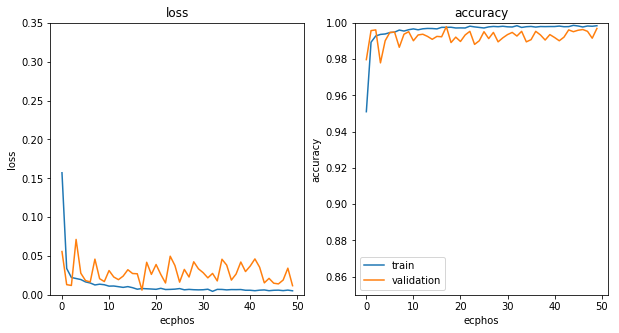

In [67]:
import h5py
import numpy as np
from sklearn.utils import shuffle
from keras.models import *
from keras.layers import *
import time

X_train = []
X_test = []
bottle_neck_files = ["bottleneck_features/VGG16_bottleneck_features.h5",
                    "bottleneck_features/VGG19_bottleneck_features.h5", 
                    "bottleneck_features/ResNet50_bottleneck_features.h5",
                    "bottleneck_features/InceptionV3_bottleneck_features.h5",
                    "bottleneck_features/Xception_bottleneck_features.h5"]

for filename in bottle_neck_files:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

print(X_train.shape[1:])

input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

start_time = time.time()

model.fit(X_train, y_train, batch_size=128, epochs=50, validation_split=0.2, verbose=0)

end_time = time.time()
    
print("Trainning model total consumed: {} seconds".format(end_time - start_time))

plot_model(model)

In [5]:
train_data_path = 'data/train/'
test_data_path = 'data/test/'

y_pred = model.predict(X_test, verbose=1)
#y_pred = y_pred.clip(min=0, max=1)

import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("data/sample_submission.csv")

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory(test_data_path, (224, 224), shuffle=False, batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('\\')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('data/pred.csv', index=None)
df.head(10)

12500/12500 [==============================] - 0s 30us/step
Found 12500 images belonging to 1 classes.


c:\users\tracy\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,id,label
0,1,9.999999e-01
1,2,1.000000e+00
2,3,9.999999e-01
3,4,9.999999e-01
4,5,5.979497e-10
5,6,1.196284e-08
6,7,1.454342e-08
7,8,2.503891e-09
8,9,3.338187e-10
9,10,3.541826e-08


In [9]:
print(X_train.shape, y_train.shape)


from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0, max_depth=10)
clf.fit(X_train, y_train)

(25000, 7168) (25000,)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [11]:
clf_pred = clf.predict(X_test)

In [12]:
for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('\\')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', clf_pred[i])

df.to_csv('data/pred.csv', index=None)
df.head(10)

c:\users\tracy\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


,id,label
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,0.0
5,6,0.0
6,7,0.0
7,8,0.0
8,9,0.0
9,10,0.0


In [1]:
import h5py
import numpy as np
import pandas as pd
from keras.models import *
from keras.layers import *
from keras.preprocessing.image import *
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from keras.optimizers import *
import time
import matplotlib.pyplot as plt
%matplotlib inline

def retrieve_features(files):
    X_train = []
    X_test = []
    y_train = []
    
    for filename in files:
        with h5py.File(filename, 'r') as h:
            X_train.append(np.array(h['train']))
            X_test.append(np.array(h['test']))
            y_train = np.array(h['label'])
        
    X_train = np.concatenate(X_train, axis=1)
    X_test = np.concatenate(X_test, axis=1)
    
    return X_train, X_test, y_train

    

def train_model(X_train, y_train, epochs, optimizer='adam', verbose=0):
    # construct model
    input_tensor = Input(X_train.shape[1:])
    x = BatchNormalization()(input_tensor)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(input_tensor, x)
    # compile model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    # train model
    start_time = time.time()
    model.fit(X_train, y_train, batch_size=200, epochs=epochs, validation_split=0.2, verbose=verbose)
    end_time = time.time()
    print("Trainning model total consumed:{:.2f} seconds".format(end_time - start_time))
    
    return model

def generate_submission_csv(X_test, model, model_name):
    start_time = time.time()
    y_pred = model.predict(X_test, verbose=0)
    end_time = time.time()
    print("Predicting model total consumed:{:.2f} seconds".format(end_time - start_time))
    y_pred = y_pred.clip(min=0.005, max=0.995)

    df = pd.read_csv("data/sample_submission.csv")

    gen = ImageDataGenerator()
    test_generator = gen.flow_from_directory('data/test/', (224, 224), shuffle=False, batch_size=32, class_mode=None)

    for i, fname in enumerate(test_generator.filenames):
        index = int(fname[fname.rfind('\\')+1:fname.rfind('.')])
        df.at[index-1, 'label'] = y_pred[i]

    df.to_csv('data/{}_pred.csv'.format(model_name), index=None)

def plot_model(model):
    train_loss = model.history.history['loss']
    train_acc = model.history.history['acc']
    val_loss = model.history.history['val_loss']
    val_acc = model.history.history['val_acc']

    niter = np.arange(len(train_loss))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(niter, train_loss, label='train')
    ax1.plot(niter, val_loss, label='validation')
    ax1.set_title("loss")
    ax1.set_xlabel('ecphos')
    ax1.set_ylabel('loss')
    ax1.set_ylim(0, 0.35)

    ax2.plot(niter, train_acc, label='train')
    ax2.plot(niter, val_acc, label='validation')
    ax2.set_title("accuracy")
    ax2.set_xlabel('ecphos')
    ax2.set_ylabel('accuracy')
    ax2.set_ylim(0.85, 1)

    plt.legend()
    plt.show()
    
    print("train max acc:{:.4f}, validation max acc:{:.4f}, train min loss:{:.4f}, validation min loss:{:.4f}" \
          .format(np.max(train_acc), np.max(val_acc), np.min(train_loss), np.min(val_loss)))

c:\users\tracy\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Trainning model total consumed:36.29 seconds


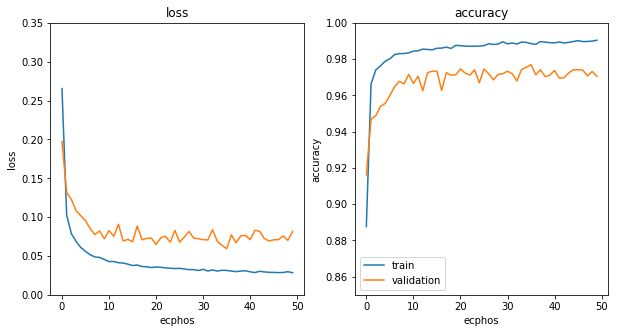

train max acc:0.9905, validation max acc:0.9770, train min loss:0.0284, validation min loss:0.0593
Predicting model total consumed:1.47 seconds
Found 12500 images belonging to 1 classes.


In [11]:
bottleneck_files = ["bottleneck_features/VGG16_bottleneck_features.h5"]

X_train, X_test, y_train = retrieve_features(bottleneck_files)

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = train_model(X_train, y_train, 50, optimizer, 0)

plot_model(model)

generate_submission_csv(X_test, model, 'VGG16')

In [ ]:
bottleneck_files = ["bottleneck_features/VGG19_bottleneck_features.h5"]

X_train, X_test, y_train = retrieve_features(bottleneck_files)

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = train_model(X_train, y_train, 200, optimizer)

plot_model(model)

generate_submission_csv(X_test, model, 'VGG19')

In [ ]:
bottleneck_files = ["bottleneck_features/ResNet50_bottleneck_features.h5"]

X_train, X_test, y_train = retrieve_features(bottleneck_files)

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = train_model(X_train, y_train, 50, optimizer)

plot_model(model)

generate_submission_csv(X_test, model, 'ResNet50')

In [ ]:
bottleneck_files = ["bottleneck_features/InceptionV3_bottleneck_features.h5"]

X_train, X_test, y_train = retrieve_features(bottleneck_files)

optimizer = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = train_model(X_train, y_train, 20, optimizer)

plot_model(model)

generate_submission_csv(X_test, model, 'InceptionV3')

In [ ]:
bottleneck_files = ["bottleneck_features/Xception_bottleneck_features.h5"]

X_train, X_test, y_train = retrieve_features(bottleneck_files)

optimizer = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = train_model(X_train, y_train, 20, optimizer)

plot_model(model)

generate_submission_csv(X_test, model, 'Xception')

In [ ]:
bottleneck_files = ["bottleneck_features/VGG16_bottleneck_features.h5",
                    "bottleneck_features/VGG19_bottleneck_features.h5", 
                    "bottleneck_features/ResNet50_bottleneck_features.h5",
                    "bottleneck_features/InceptionV3_bottleneck_features.h5",
                    "bottleneck_features/Xception_bottleneck_features.h5"]

X_train, X_test, y_train = retrieve_features(bottleneck_files)

optimizer = Adam(lr=0.00007, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)

model = train_model(X_train, y_train, 50, optimizer)

plot_model(model)

generate_submission_csv(X_test, model, 'All_models')